Starting simulation...
Initial: {'n_grains': 28, 'rex_fraction': np.float64(0.0003), 'n_interfaces': 1768}
Step 0: t=0.000000s, Rex=0.000, Grains=28, Switched=0
Step 50: t=0.000000s, Rex=0.373, Grains=27, Switched=0
Step 100: t=0.000000s, Rex=0.896, Grains=16, Switched=0
Steady state reached at step 140


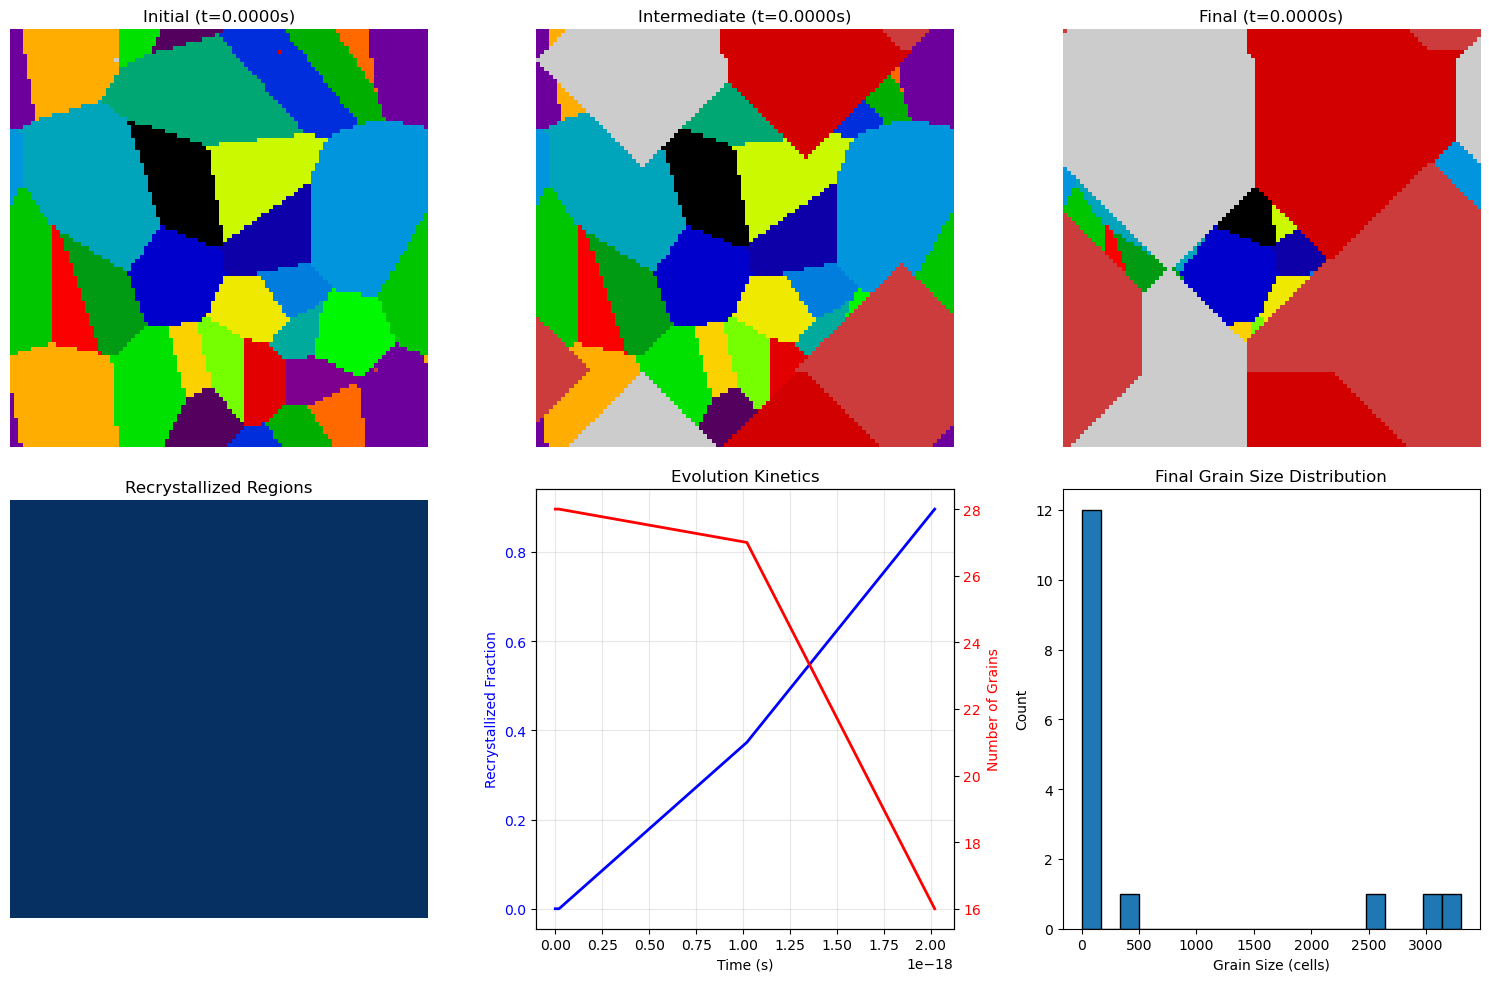

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from dataclasses import dataclass
from typing import List, Tuple, Dict
import random

@dataclass
class CellularAutomatonRexGG:
    """
    Cellular Automaton for Recrystallization and Grain Growth
    """
    nx: int = 100
    ny: int = 100
    dx: float = 1e-6  # Cell size in meters
    
    # Material parameters
    grain_boundary_energy: float = 0.5  # J/m^2
    grain_boundary_mobility_0: float = 1e-6  # m^4/(J·s)
    
    # Misorientation parameters
    lower_misorientation_cutoff: float = 2.0  # degrees
    lower_misorientation_lagb: float = 5.0    # degrees
    hagb_threshold: float = 15.0              # degrees
    
    # Rex parameters
    stored_energy_factor: float = 5e5  # J/m^3 per unit dislocation density
    
    # Kinetic correction factor
    beta_factor: float = 0.5
    
    def __init__(self):
        self.n_cells = self.nx * self.ny
        
        # Cell properties
        self.orientation_id = np.zeros(self.n_cells, dtype=int)
        self.euler_angles = {}  # Dict mapping ori_id to (phi1, Phi, phi2)
        self.is_recrystallized = np.zeros(self.n_cells, dtype=bool)
        self.dislocation_density = np.ones(self.n_cells) * 1e14  # 1/m^2
        self.consumption_rate = np.zeros(self.n_cells)
        self.consumed_fraction = np.zeros(self.n_cells)
        self.neighbor_to_grow = -np.ones(self.n_cells, dtype=int)
        
        # Interface tracking
        self.interface_cells = set()
        
        # Misorientation cache for efficiency
        self.misorientation_cache = {}
        
        # Initialize microstructure
        self._initialize_microstructure()
        self._identify_interfaces()
        
    def _initialize_microstructure(self):
        """Initialize with random grain structure and some recrystallization nuclei"""
        # Create initial grain structure using Voronoi tessellation
        n_grains = 25
        
        # Generate seed points
        seed_x = np.random.randint(0, self.nx, n_grains)
        seed_y = np.random.randint(0, self.ny, n_grains)
        
        # Generate unique Euler angles for each initial grain
        for grain_id in range(n_grains):
            phi1 = np.random.uniform(0, 360)
            Phi = np.random.uniform(0, 180)
            phi2 = np.random.uniform(0, 360)
            self.euler_angles[grain_id] = (phi1, Phi, phi2)
        
        # Assign grains based on closest seed
        for i in range(self.nx):
            for j in range(self.ny):
                cell_idx = self._ij_to_index(i, j)
                
                # Find closest seed considering periodic boundaries
                min_dist = float('inf')
                closest_grain = 0
                
                for g in range(n_grains):
                    # Periodic distance
                    dx = min(abs(i - seed_x[g]), self.nx - abs(i - seed_x[g]))
                    dy = min(abs(j - seed_y[g]), self.ny - abs(j - seed_y[g]))
                    dist = dx*dx + dy*dy
                    
                    if dist < min_dist:
                        min_dist = dist
                        closest_grain = g
                
                self.orientation_id[cell_idx] = closest_grain
        
        # Add recrystallization nuclei
        n_nuclei = 3
        
        # Select random positions for nuclei
        nuclei_positions = np.random.choice(self.n_cells, n_nuclei, replace=False)
        
        # Create new orientations for rex grains
        rex_ori_start = len(self.euler_angles)
        for i, pos in enumerate(nuclei_positions):
            new_ori_id = rex_ori_start + i
            
            # Generate new orientation
            phi1 = np.random.uniform(0, 360)
            Phi = np.random.uniform(0, 180)
            phi2 = np.random.uniform(0, 360)
            self.euler_angles[new_ori_id] = (phi1, Phi, phi2)
            
            # Set rex nucleus
            self.orientation_id[pos] = new_ori_id
            self.is_recrystallized[pos] = True
            self.dislocation_density[pos] = 1e10  # Low dislocation density
            
    def _identify_interfaces(self):
        """Identify grain boundary cells"""
        self.interface_cells.clear()
        
        for i in range(self.n_cells):
            neighbors = self._get_neighbors(i)
            
            for j in neighbors:
                if self.orientation_id[i] != self.orientation_id[j]:
                    mis = self._calculate_misorientation(
                        self.orientation_id[i], 
                        self.orientation_id[j]
                    )
                    if mis >= self.lower_misorientation_lagb:
                        self.interface_cells.add(i)
                        break
                        
    def _get_neighbors(self, cell_idx: int) -> List[int]:
        """Get Von Neumann neighbors (4-connected in 2D)"""
        i, j = self._index_to_ij(cell_idx)
        neighbors = []
        
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni = (i + di) % self.nx
            nj = (j + dj) % self.ny
            neighbors.append(self._ij_to_index(ni, nj))
            
        return neighbors
    
    def _get_all_neighbors(self, cell_idx: int) -> List[int]:
        """Get Moore neighbors (8-connected in 2D)"""
        i, j = self._index_to_ij(cell_idx)
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                    
                ni = (i + di) % self.nx
                nj = (j + dj) % self.ny
                neighbors.append(self._ij_to_index(ni, nj))
                
        return neighbors
    
    def _index_to_ij(self, idx: int) -> Tuple[int, int]:
        return idx // self.ny, idx % self.ny
    
    def _ij_to_index(self, i: int, j: int) -> int:
        return i * self.ny + j
    
    def _calculate_misorientation(self, ori_id1: int, ori_id2: int) -> float:
        """Calculate misorientation between two orientations"""
        if ori_id1 == ori_id2:
            return 0.0
        
        # Check cache
        key = (min(ori_id1, ori_id2), max(ori_id1, ori_id2))
        if key in self.misorientation_cache:
            return self.misorientation_cache[key]
        
        # Get Euler angles
        euler1 = self.euler_angles[ori_id1]
        euler2 = self.euler_angles[ori_id2]
        
        # Simplified misorientation calculation
        # In practice, this should use proper quaternion operations
        diff_phi1 = abs(euler1[0] - euler2[0])
        diff_phi1 = min(diff_phi1, 360 - diff_phi1)
        
        diff_Phi = abs(euler1[1] - euler2[1])
        
        diff_phi2 = abs(euler1[2] - euler2[2])
        diff_phi2 = min(diff_phi2, 360 - diff_phi2)
        
        # Weighted combination
        mis = 0.4 * diff_phi1 + 0.3 * diff_Phi + 0.3 * diff_phi2
        
        # Ensure reasonable range
        mis = min(mis, 62.8)
        
        # Cache result
        self.misorientation_cache[key] = mis
        
        return mis
    
    def _get_boundary_energy(self, misorientation: float) -> float:
        """Read-Shockley boundary energy model"""
        if misorientation < self.lower_misorientation_cutoff:
            return 0.0
            
        if misorientation >= self.hagb_threshold:
            return self.grain_boundary_energy
            
        # Read-Shockley equation
        theta_m = self.hagb_threshold * np.pi / 180.0  # Convert to radians
        theta = misorientation * np.pi / 180.0
        
        return self.grain_boundary_energy * (theta / theta_m) * (1 - np.log(theta / theta_m))
    
    def _get_mobility(self, misorientation: float) -> float:
        """Misorientation-dependent mobility"""
        if misorientation < self.lower_misorientation_cutoff:
            return 0.0
            
        M0 = self.grain_boundary_mobility_0
        
        if misorientation >= self.hagb_threshold:
            return M0
            
        # Sigmoid-like function for mobility
        r = misorientation / self.hagb_threshold
        return M0 * r * r  # Simplified compared to Humphreys
    
    def calculate_consumption_rates(self) -> float:
        """Calculate consumption rates for all interface cells"""
        max_rate = 0.0
        
        # Reset
        self.consumption_rate.fill(0.0)
        self.neighbor_to_grow.fill(-1)
        
        for cell_idx in self.interface_cells:
            current_ori = self.orientation_id[cell_idx]
            neighbors = self._get_neighbors(cell_idx)
            
            # Calculate current state energy
            current_energy = 0.0
            for nbr in self._get_all_neighbors(cell_idx):
                mis = self._calculate_misorientation(
                    current_ori,
                    self.orientation_id[nbr]
                )
                current_energy += self._get_boundary_energy(mis)
            
            # Stored energy contribution
            stored_energy = self.stored_energy_factor * self.dislocation_density[cell_idx]
            
            # Try each different neighbor orientation
            best_rate = 0.0
            best_neighbor = -1
            
            for nbr_idx in neighbors:
                nbr_ori = self.orientation_id[nbr_idx]
                
                if nbr_ori == current_ori:
                    continue
                
                boundary_mis = self._calculate_misorientation(current_ori, nbr_ori)
                
                if boundary_mis < self.lower_misorientation_lagb:
                    continue
                
                # Calculate new state energy
                new_energy = 0.0
                for other_nbr in self._get_all_neighbors(cell_idx):
                    mis = self._calculate_misorientation(
                        nbr_ori,
                        self.orientation_id[other_nbr]
                    )
                    new_energy += self._get_boundary_energy(mis)
                
                # Driving force calculation
                energy_reduction = current_energy - new_energy
                
                # Add stored energy difference for recrystallization
                if self.is_recrystallized[nbr_idx] and not self.is_recrystallized[cell_idx]:
                    # Rex grain consuming deformed matrix
                    driving_force = energy_reduction + stored_energy
                else:
                    # Pure grain growth
                    driving_force = energy_reduction
                
                if driving_force <= 0:
                    continue
                
                # Mobility
                mobility = self._get_mobility(boundary_mis)
                
                # Rate = mobility * driving_force * area/volume
                area_per_volume = 1.0 / self.dx
                rate = mobility * driving_force * area_per_volume * self.beta_factor
                
                if rate > best_rate:
                    best_rate = rate
                    best_neighbor = nbr_idx
            
            self.consumption_rate[cell_idx] = best_rate
            self.neighbor_to_grow[cell_idx] = best_neighbor
            
            max_rate = max(max_rate, best_rate)
        
        return max_rate
    
    def update_cells(self, dt: float) -> int:
        """Update cells based on consumption"""
        n_switched = 0
        cells_to_switch = []
        
        # Update consumed fractions
        for cell_idx in self.interface_cells:
            if self.consumption_rate[cell_idx] > 0:
                self.consumed_fraction[cell_idx] += self.consumption_rate[cell_idx] * dt
                
                if self.consumed_fraction[cell_idx] >= 1.0:
                    cells_to_switch.append(cell_idx)
        
        # Perform switching
        for cell_idx in cells_to_switch:
            nbr_idx = int(self.neighbor_to_grow[cell_idx])
            if nbr_idx >= 0:
                # Copy orientation from growing neighbor
                self.orientation_id[cell_idx] = self.orientation_id[nbr_idx]
                
                # Update recrystallization status
                if self.is_recrystallized[nbr_idx]:
                    self.is_recrystallized[cell_idx] = True
                    self.dislocation_density[cell_idx] = self.dislocation_density[nbr_idx]
                
                # Reset
                self.consumed_fraction[cell_idx] = 0.0
                n_switched += 1
        
        # Update interfaces
        if n_switched > 0:
            self._identify_interfaces()
        
        return n_switched
    
    def simulate_step(self) -> Tuple[float, int]:
        """Perform one simulation step"""
        max_rate = self.calculate_consumption_rates()
        
        if max_rate < 1e-12:
            return 0.0, 0
        
        # Time step
        dt = 0.5 / max_rate
        
        # Update
        n_switched = self.update_cells(dt)
        
        return dt, n_switched
    
    def get_microstructure_map(self) -> np.ndarray:
        return self.orientation_id.reshape(self.nx, self.ny)
    
    def get_rex_map(self) -> np.ndarray:
        return self.is_recrystallized.reshape(self.nx, self.ny)
    
    def get_statistics(self) -> Dict:
        unique_oris = np.unique(self.orientation_id)
        return {
            'n_grains': len(unique_oris),
            'rex_fraction': np.mean(self.is_recrystallized),
            'n_interfaces': len(self.interface_cells)
        }

# Run simulation
def run_simulation():
    ca = CellularAutomatonRexGG()
    
    history = {
        'time': [],
        'rex_fraction': [],
        'n_grains': [],
        'microstructure': []
    }
    
    total_time = 0.0
    max_steps = 2000
    
    print("Starting simulation...")
    initial_stats = ca.get_statistics()
    print(f"Initial: {initial_stats}")
    
    # Store initial state
    history['time'].append(0.0)
    history['rex_fraction'].append(initial_stats['rex_fraction'])
    history['n_grains'].append(initial_stats['n_grains'])
    history['microstructure'].append(ca.get_microstructure_map().copy())
    
    for step in range(max_steps):
        dt, n_switched = ca.simulate_step()
        
        if dt == 0:
            print(f"Steady state reached at step {step}")
            break
            
        total_time += dt
        
        if step % 50 == 0:
            stats = ca.get_statistics()
            history['time'].append(total_time)
            history['rex_fraction'].append(stats['rex_fraction'])
            history['n_grains'].append(stats['n_grains'])
            history['microstructure'].append(ca.get_microstructure_map().copy())
            
            print(f"Step {step}: t={total_time:.6f}s, "
                  f"Rex={stats['rex_fraction']:.3f}, "
                  f"Grains={stats['n_grains']}, "
                  f"Switched={n_switched}")
    
    return ca, history

# Visualization
def visualize_results(ca, history):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Microstructures at different times
    indices = [0, len(history['microstructure'])//2, -1]
    titles = ['Initial', 'Intermediate', 'Final']
    
    for i, (idx, title) in enumerate(zip(indices, titles)):
        im = axes[0, i].imshow(history['microstructure'][idx], cmap='nipy_spectral')
        axes[0, i].set_title(f'{title} (t={history["time"][idx]:.4f}s)')
        axes[0, i].axis('off')
    
    # Rex map
    axes[1, 0].imshow(ca.get_rex_map(), cmap='RdBu_r')
    axes[1, 0].set_title('Recrystallized Regions')
    axes[1, 0].axis('off')
    
    # Kinetics
    ax1 = axes[1, 1]
    ax1.plot(history['time'], history['rex_fraction'], 'b-', linewidth=2)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Recrystallized Fraction', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(history['time'], history['n_grains'], 'r-', linewidth=2)
    ax2.set_ylabel('Number of Grains', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_title('Evolution Kinetics')
    
    # Final grain size distribution
    final_micro = history['microstructure'][-1]
    grain_sizes = []
    for grain_id in np.unique(final_micro):
        size = np.sum(final_micro == grain_id)
        grain_sizes.append(size)
    
    axes[1, 2].hist(grain_sizes, bins=20, edgecolor='black')
    axes[1, 2].set_xlabel('Grain Size (cells)')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Final Grain Size Distribution')
    
    plt.tight_layout()
    plt.show()

# Execute
if __name__ == "__main__":
    ca, history = run_simulation()
    visualize_results(ca, history)